In [1]:
from large_gcs.algorithms.search_algorithm import AlgMetrics, SearchNode
from large_gcs.domination_checkers.reaches_new_containment import ReachesNewContainment
from large_gcs.graph_generators.hor_vert_gcs import create_polyhedral_hor_vert_b_graph
from pydrake.all import (MathematicalProgram,
                         DecomposeAffineExpressions,
                         DecomposeLinearExpressions,
                )
import pypolycontain as pp
import numpy as np


/Users/chewchiashaoyuan/Documents/Software/pypolycontain/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/Users/chewchiashaoyuan/Documents/Software/pypolycontain/pypolycontain/containment.py:16: UserWarning: You don't have CDD package installed. Unable to run cone ray generation.
  warnings.warn("You don't have CDD package installed. Unable to run cone ray generation.")


The goal of this notebook is to work through rewriting Sadra's subset function to the add constraint function signatures where the variables are passed in separately which is more efficient than the variant where you pass in expressions and Drake has to parse them.

In [2]:

def original_subset(program,inbody,circumbody,k=-1,Theta=None,i=0,alpha=None,verbose=False):
    """
    Adds containment property Q1 subset Q2
    
    Inputs:
        * program: a `pydrake` mathematical program
        * inbody: a polytopic object
        * circumbody: a polytopic object
        * N: 
            * **Default**: :math:`-1``. Sufficient as in [Sadraddini and Tedrake, 2019]
            * pick `0` for necessary and sufficient encoding (may be too slow) 
            as in [Sadraddini and Tedrake, 2019]
            * pick any positive number. As the number is smaller, 
            the condition becomes closer to necessity. However, this may be too slow.
    
    Output:
        * No direct output, adds :\math:`inbody \subseteq circumbody` to the model
    """
    Q1=pp.to_AH_polytope(inbody)
    Q2=pp.to_AH_polytope(circumbody)
    Hx,Hy,hx,hy,X,Y,xbar,ybar=Q1.P.H,Q2.P.H,Q1.P.h,Q2.P.h,Q1.T,Q2.T,Q1.t,Q2.t
    qx,qy,nx,ny=Hx.shape[0],Hy.shape[0],X.shape[1],Y.shape[1]
    if type(Theta)!=type(None):
        if verbose:
            print("theta already computed")
        pass
    elif k<0:
        Theta=np.eye(qy)
        if verbose:
            print("Using Positive Orthant")
    else:
        if verbose:
            print("*"*20)
            print("\n")
            print("Computing theta with k=%d"%k)
        Theta=pp.theta_k(circumbody,k,i)
        if verbose:
            print("The maximum for k can be ",circumbody.dim_complement)
            print("Theta Size is=",Theta.shape)
            print("*"*20)
            print("\n")
    Lambda=program.NewContinuousVariables(Theta.shape[1],qx,'Lambda')
    Gamma=program.NewContinuousVariables(ny,nx,'Gamma')
    gamma=program.NewContinuousVariables(ny,1,'gamma')
    # Constraints
    program.AddBoundingBoxConstraint(0,np.inf,Lambda) # Lambda Non-Negative
    
    # Constraint 1
    program.AddLinearConstraint(np.equal(X,np.dot(Y,Gamma),dtype='object').flatten()) #X=YGamma
    
    program.AddLinearConstraint(np.equal(ybar-xbar,np.dot(Y,gamma),dtype='object').flatten()) 
    
    program.AddLinearConstraint(np.equal(np.dot(Lambda,Hx),np.dot(Theta.T,np.dot(Hy,Gamma)),dtype='object').flatten()) 
    
    program.AddLinearConstraint(np.less_equal(np.dot(Lambda,hx),\
          np.dot(Theta.T,hy)+np.dot(Theta.T,np.dot(Hy,gamma)),dtype='object').flatten())
    
    print("Shapes of matrix variables:")
    print("Hx:", Hx.shape)
    print("Hy:", Hy.shape)
    print("hx:", hx.shape)
    print("hy:", hy.shape)
    print("X:", X.shape)
    print("Y:", Y.shape)
    print("xbar:", xbar.shape)
    print("ybar:", ybar.shape)
    print("Theta shape:", Theta.shape)
    print("Decision variable shapes:")
    print("Lambda:", (Theta.shape[1], qx))
    print("Gamma:", (ny, nx))
    print("gamma:", (ny, 1))


    return Theta,Lambda,Gamma,gamma

In [3]:
def new_subset(program, inbody, circumbody, k=-1, Theta=None, i=0, alpha=None, verbose=False):
    """
    Adds containment property Q1 subset Q2
    
    Inputs:
        * program: a `pydrake` mathematical program
        * inbody: a polytopic object
        * circumbody: a polytopic object
        * k: 
            * **Default**: -1. Sufficient as in [Sadraddini and Tedrake, 2019]
            * Pick 0 for necessary and sufficient encoding (may be too slow) 
            as in [Sadraddini and Tedrake, 2019]
            * Pick any positive number. As the number is smaller, 
            the condition becomes closer to necessity. However, this may be too slow.
        * Theta: 
            * **Default**: None. If provided, the function will use the provided Theta.
            * If not provided, the function will compute Theta using `pp.theta_k`.
        * i: 
            * **Default**: 0. The index used in `pp.theta_k` function.
        * alpha: 
            * **Default**: None. Not used in the function.
        * verbose: 
            * **Default**: False. If True, the function will print additional information during execution.
    
    Output:
        * Theta: The computed or provided Theta matrix.
        * Lambda: The created continuous variables for Lambda.
        * Gamma: The created continuous variables for Gamma.
        * gamma: The created continuous variables for gamma.
    """
    Q1 = pp.to_AH_polytope(inbody)
    Q2 = pp.to_AH_polytope(circumbody)
    Hx, Hy, hx, hy, X, Y, xbar, ybar = Q1.P.H, Q2.P.H, Q1.P.h, Q2.P.h, Q1.T, Q2.T, Q1.t, Q2.t
    qx, qy, nx, ny = Hx.shape[0], Hy.shape[0], X.shape[1], Y.shape[1]
    
    if type(Theta) != type(None):
        if verbose:
            print("Theta already computed")
        pass
    elif k < 0:
        Theta = np.eye(qy)
        if verbose:
            print("Using Positive Orthant")
    else:
        if verbose:
            print("*" * 20)
            print("\n")
            print("Computing theta with k=%d" % k)
        Theta = pp.theta_k(circumbody, k, i)
        if verbose:
            print("The maximum for k can be ", circumbody.dim_complement)
            print("Theta Size is=", Theta.shape)
            print("*" * 20)
            print("\n")
    
    Lambda = program.NewContinuousVariables(Theta.shape[1], qx, 'Lambda')
    Gamma = program.NewContinuousVariables(ny, nx, 'Gamma')
    gamma = program.NewContinuousVariables(ny, 1, 'gamma')
    
    # Constraints
    # Constraint 1: Lambda Non-Negative
    program.AddBoundingBoxConstraint(0, np.inf, Lambda)

    # Constraint 2: X = YGamma
    Aeq_2 = DecomposeLinearExpressions(np.dot(Y, Gamma).flatten(), Gamma.flatten())
    # Originally proposed np.kron(Y, np.eye(ny)), but this leads to errors
    proposed_Aeq_2 = np.kron(Y, np.eye(nx)) # this seems to work but not sure if it works in general
    program.AddLinearEqualityConstraint(Aeq=proposed_Aeq_2, beq=X.flatten(), vars=Gamma.flatten())

    # Constraint 3: ybar - xbar = Ygamma
    program.AddLinearEqualityConstraint(Aeq=Y, beq=(ybar - xbar), vars=gamma)

    # Constraint 4: Lambda Hx = Theta^T Hy Gamma
    # program.AddLinearConstraint(np.equal(np.dot(Lambda, Hx), np.dot(Theta.T, np.dot(Hy, Gamma)), dtype='object').flatten()) 
    Gamma_Lambda_flat = np.concatenate((Gamma.flatten(), Lambda.flatten()))
    exprs_matrix_4 = (Theta.T @ Hy @ Gamma - Lambda @ Hx)
    Aeq_4 = DecomposeLinearExpressions(exprs_matrix_4.flatten(), Gamma_Lambda_flat)
    # program.AddLinearEqualityConstraint(Aeq=Aeq_4, beq=np.zeros(Aeq_4.shape[1]), vars=Gamma_Lambda_flat)

    # Constraint 5: Lambda hx <= Theta^T hy + Theta^T Hy gamma
    # program.AddLinearConstraint(np.less_equal(np.dot(Lambda, hx), np.dot(Theta.T, hy) + np.dot(Theta.T, np.dot(Hy, gamma)), dtype='object').flatten())

    ThetaHy = Theta.T @ Hy
    for i in range(Lambda.shape[0]):
        for j in range(Hx.shape[1]):
            program.AddLinearEqualityConstraint(np.hstack((Hx[:,j], -ThetaHy[i])), 0, np.hstack((Lambda[i], Gamma[:, j])))
        program.AddLinearConstraint(np.hstack((hx.flatten(), - ThetaHy[i])), -np.inf, np.dot(Theta[:, i], hy), np.hstack((Lambda[i], gamma.flatten())))
    

    print("Constraint 2")
    print("np.dot(Y,Gamma).shape:", np.dot(Y,Gamma).shape)
    print("np.dot(Y,Gamma):", np.dot(Y,Gamma))
    print("Aeq_2.shape:", Aeq_2.shape)
    # print("Aeq:\n", Aeq)
    YGamma_flat = Aeq_2 @ Gamma.flatten()
    YGamma_flat = proposed_Aeq_2 @ Gamma.flatten()
    print("YGamma_flat.shape:", YGamma_flat.shape)
    print("YGamma_flat:", YGamma_flat)
    print("Are they equal?", np.allclose(Aeq_2, proposed_Aeq_2))

    # print("Constraint 4:")
    # print("exprs_matrix_4.shape:", exprs_matrix_4.shape)
    # print("exprs_matrix_4.flatten():", exprs_matrix_4.flatten())
    # print("Aeq_4.shape:", Aeq_4.shape)
    # result_4_flat = Aeq_4 @ Gamma_Lambda_flat
    # print("result_4_flat.shape:", result_4_flat.shape)
    # print("result_4_flat:", result_4_flat)
    # print("Gamma_Lambda_flat.shape:", Gamma_Lambda_flat.shape)

    
    return Theta, Lambda, Gamma, gamma


In [4]:
def test_reaches_new_containment_polyhedral_hor_vert_b_graph(use_original):
    G = create_polyhedral_hor_vert_b_graph()
    domination_checker = ReachesNewContainment(graph=G, containment_condition=-1)
    domination_checker.set_alg_metrics(AlgMetrics())
    n_x = SearchNode.from_vertex_path(["s", "p1", "p2"])
    n_y = SearchNode.from_vertex_path(["s", "p6", "p7", "p2"])
    n_z = SearchNode.from_vertex_path(["s", "p8", "p9", "p2"])

    def new_is_contained_in(A_x, b_x, T_x, A_y, b_y, T_y):
        self = domination_checker
        AH_X, AH_Y = self._create_AH_polytopes(A_x, b_x, T_x, A_y, b_y, T_y)

        prog = MathematicalProgram()

        # https://github.com/sadraddini/pypolycontain/blob/master/pypolycontain/containment.py#L123
        # -1 for sufficient condition
        # pick `0` for necessary and sufficient encoding (may be too slow) (2019b)
        if use_original:
            original_subset(prog, AH_X, AH_Y, self._containment_condition)
        else:
            new_subset(prog, AH_X, AH_Y, self._containment_condition)
        
        return self._solve_containment_prog(prog)
    
    domination_checker.is_contained_in = new_is_contained_in

    res = domination_checker.is_dominated(candidate_node=n_x, alternate_nodes=[n_y])
    print(f"result (should be True): {res}")
    assert res
    assert not domination_checker.is_dominated(
        candidate_node=n_y, alternate_nodes=[n_x]
    )
    assert domination_checker.is_dominated(candidate_node=n_z, alternate_nodes=[n_x])

    # The union of n_b, n_c, and n_d does dominate n_a,
    # but individually they do not, so this check should return false.
    n_a = SearchNode.from_vertex_path(["s", "p0", "p2"])
    n_b = SearchNode.from_vertex_path(["s", "p3", "p2"])
    n_c = SearchNode.from_vertex_path(["s", "p4", "p2"])
    n_d = SearchNode.from_vertex_path(["s", "p5", "p2"])
    assert not domination_checker.is_dominated(
        candidate_node=n_a, alternate_nodes=[n_b, n_c, n_d])

In [5]:
test_reaches_new_containment_polyhedral_hor_vert_b_graph(use_original=True)

100%|██████████| 12/12 [00:00<00:00, 18907.46it/s]


Shapes of matrix variables:
Hx: (16, 6)
Hy: (22, 8)
hx: (16, 1)
hy: (22, 1)
X: (2, 6)
Y: (2, 8)
xbar: (2, 1)
ybar: (2, 1)
Theta shape: (22, 22)
Decision variable shapes:
Lambda: (22, 16)
Gamma: (8, 6)
gamma: (8, 1)
result (should be True): True
Shapes of matrix variables:
Hx: (22, 8)
Hy: (16, 6)
hx: (22, 1)
hy: (16, 1)
X: (2, 8)
Y: (2, 6)
xbar: (2, 1)
ybar: (2, 1)
Theta shape: (16, 16)
Decision variable shapes:
Lambda: (16, 22)
Gamma: (6, 8)
gamma: (6, 1)
Shapes of matrix variables:
Hx: (22, 8)
Hy: (16, 6)
hx: (22, 1)
hy: (16, 1)
X: (2, 8)
Y: (2, 6)
xbar: (2, 1)
ybar: (2, 1)
Theta shape: (16, 16)
Decision variable shapes:
Lambda: (16, 22)
Gamma: (6, 8)
gamma: (6, 1)
Shapes of matrix variables:
Hx: (16, 6)
Hy: (15, 6)
hx: (16, 1)
hy: (15, 1)
X: (2, 6)
Y: (2, 6)
xbar: (2, 1)
ybar: (2, 1)
Theta shape: (15, 15)
Decision variable shapes:
Lambda: (15, 16)
Gamma: (6, 6)
gamma: (6, 1)
Shapes of matrix variables:
Hx: (16, 6)
Hy: (15, 6)
hx: (16, 1)
hy: (15, 1)
X: (2, 6)
Y: (2, 6)
xbar: (2, 1)
y

In [6]:
test_reaches_new_containment_polyhedral_hor_vert_b_graph(use_original=False)

100%|██████████| 12/12 [00:00<00:00, 78276.28it/s]


Constraint 2
np.dot(Y,Gamma).shape: (2, 6)
np.dot(Y,Gamma): [[<Expression "Gamma(6,0)"> <Expression "Gamma(6,1)">
  <Expression "Gamma(6,2)"> <Expression "Gamma(6,3)">
  <Expression "Gamma(6,4)"> <Expression "Gamma(6,5)">]
 [<Expression "Gamma(7,0)"> <Expression "Gamma(7,1)">
  <Expression "Gamma(7,2)"> <Expression "Gamma(7,3)">
  <Expression "Gamma(7,4)"> <Expression "Gamma(7,5)">]]
Aeq_2.shape: (12, 48)
YGamma_flat.shape: (12,)
YGamma_flat: [<Expression "Gamma(6,0)"> <Expression "Gamma(6,1)">
 <Expression "Gamma(6,2)"> <Expression "Gamma(6,3)">
 <Expression "Gamma(6,4)"> <Expression "Gamma(6,5)">
 <Expression "Gamma(7,0)"> <Expression "Gamma(7,1)">
 <Expression "Gamma(7,2)"> <Expression "Gamma(7,3)">
 <Expression "Gamma(7,4)"> <Expression "Gamma(7,5)">]
Are they equal? True
result (should be True): True
Constraint 2
np.dot(Y,Gamma).shape: (2, 8)
np.dot(Y,Gamma): [[<Expression "Gamma(4,0)"> <Expression "Gamma(4,1)">
  <Expression "Gamma(4,2)"> <Expression "Gamma(4,3)">
  <Expression "

100%|██████████| 12/12 [00:00<00:00, 50181.10it/s]


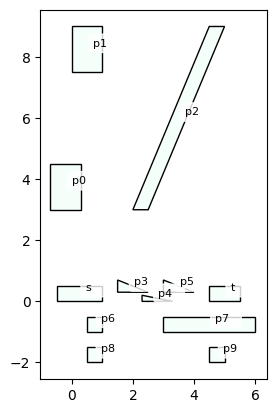

In [7]:
G = create_polyhedral_hor_vert_b_graph()
G.plot_sets()
G.plot_set_labels()